# 02 — Trend signal construction and look-ahead bias

Purpose:
- Define a simple trend-following signal using past price information only.
- Demonstrate how look-ahead bias can arise unintentionally.
- Construct a properly lagged trading signal suitable for backtesting.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = Path("../data/processed/SPY_daily_with_returns.csv")

df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
df = df.sort_index()

df.head()

,Adj Close,Close,High,Low,Open,Volume,ret_simple,ret_log,vol_20d_ann
Date,,,,,,,,,
1993-01-29,24.241404,43.93750,43.96875,43.75000,43.96875,1003200,NaN,NaN,NaN
1993-02-01,24.413826,44.25000,44.25000,43.96875,43.96875,480500,0.007113,0.007088,NaN
1993-02-02,24.465551,44.34375,44.37500,44.12500,44.21875,201300,0.002119,0.002116,NaN
1993-02-03,24.724171,44.81250,44.84375,44.37500,44.40625,529400,0.010571,0.010515,NaN
1993-02-04,24.827604,45.00000,45.09375,44.46875,44.96875,531500,0.004184,0.004175,NaN


A trend-following signal attempts to identify whether prices have been rising or falling
over a recent historical window.

The simplest possible trend rule:
- If price today is above its recent average → trend is positive
- If price today is below its recent average → trend is negative

Crucially, the signal must use **only information available at the time**.


In [3]:
# Trend window (200 trading days ≈ 1 year)
WINDOW = 200

df["ma_200"] = df["Adj Close"].rolling(WINDOW).mean()

df[["Adj Close", "ma_200"]].head(210)

,Adj Close,ma_200
Date,,
1993-01-29,24.241404,NaN
1993-02-01,24.413826,NaN
1993-02-02,24.465551,NaN
1993-02-03,24.724171,NaN
1993-02-04,24.827604,NaN
...,...,...
1993-11-19,26.015469,25.210628
1993-11-22,25.857475,25.215864
1993-11-23,25.997900,25.222664


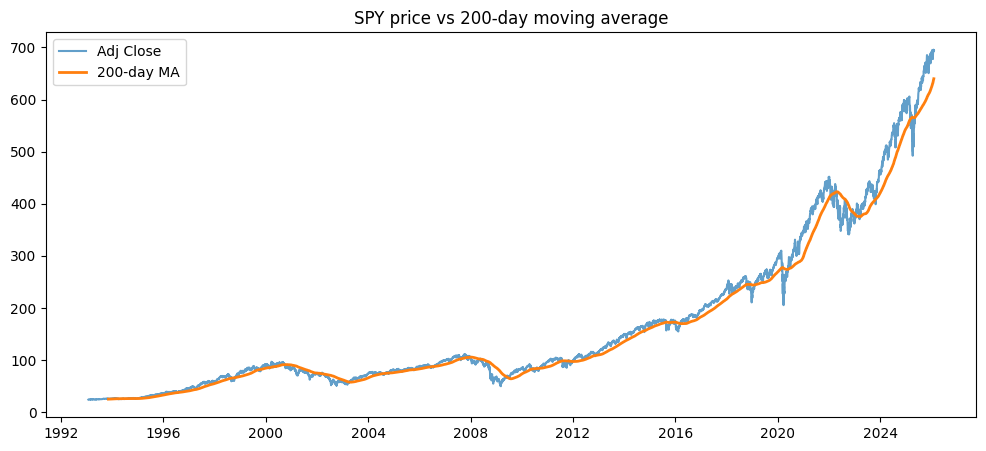

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Adj Close"], label="Adj Close", alpha=0.7)
plt.plot(df.index, df["ma_200"], label="200-day MA", linewidth=2)
plt.legend()
plt.title("SPY price vs 200-day moving average")
plt.show()

In [5]:
# Naïve signal (do NOT use)
df["signal_naive"] = np.where(df["Adj Close"] > df["ma_200"], 1, 0)

df[["Adj Close", "ma_200", "signal_naive"]].head(210)

,Adj Close,ma_200,signal_naive
Date,,,
1993-01-29,24.241404,NaN,0
1993-02-01,24.413826,NaN,0
1993-02-02,24.465551,NaN,0
1993-02-03,24.724171,NaN,0
1993-02-04,24.827604,NaN,0
...,...,...,...
1993-11-19,26.015469,25.210628,1
1993-11-22,25.857475,25.215864,1
1993-11-23,25.997900,25.222664,1


In [6]:
# Correct signal: compute today, trade tomorrow
df["signal"] = df["signal_naive"].shift(1)

In [7]:
df[["Adj Close", "ma_200", "signal_naive", "signal"]].iloc[195:215]

,Adj Close,ma_200,signal_naive,signal
Date,,,,
1993-11-05,25.875046,NaN,0,0.0
1993-11-08,25.910128,NaN,0,0.0
1993-11-09,25.927702,NaN,0,0.0
1993-11-10,26.120800,NaN,0,0.0
1993-11-11,26.050577,25.163893,1,0.0
1993-11-12,26.173458,25.173553,1,1.0
1993-11-15,26.155890,25.182263,1,1.0
1993-11-16,26.278776,25.191329,1,1.0
1993-11-17,26.138350,25.198400,1,1.0


In [8]:
# Drop rows where signal or returns are undefined
df_signal = df.dropna(subset=["signal", "ret_simple"]).copy()

print("Rows before:", len(df))
print("Rows after :", len(df_signal))

Rows before: 8310
Rows after : 8309


In [9]:
df_signal["signal"].value_counts()

signal
1.0    6248
0.0    2061
Name: count, dtype: int64

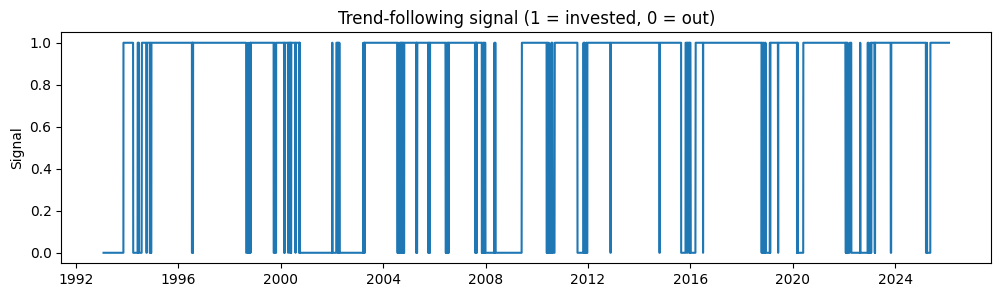

In [10]:
plt.figure(figsize=(12, 3))
plt.plot(df_signal.index, df_signal["signal"])
plt.title("Trend-following signal (1 = invested, 0 = out)")
plt.ylabel("Signal")
plt.show()

In [11]:
WINDOW = 200

df["ma_200"] = df["Adj Close"].rolling(WINDOW).mean()

# Naïve signal uses today's close relative to today's MA (not tradable at today's close)
df["signal_naive"] = (df["Adj Close"] > df["ma_200"]).astype(int)

# Correct signal: you can only trade based on information known at end of yesterday
df["signal_lagged"] = df["signal_naive"].shift(1)

In [12]:
# "Cheating" return: uses today's signal to earn today's return
df["ret_strategy_cheat"] = df["signal_naive"] * df["ret_simple"]

# Correct return: uses yesterday's signal to earn today's return
df["ret_strategy_correct"] = df["signal_lagged"] * df["ret_simple"]

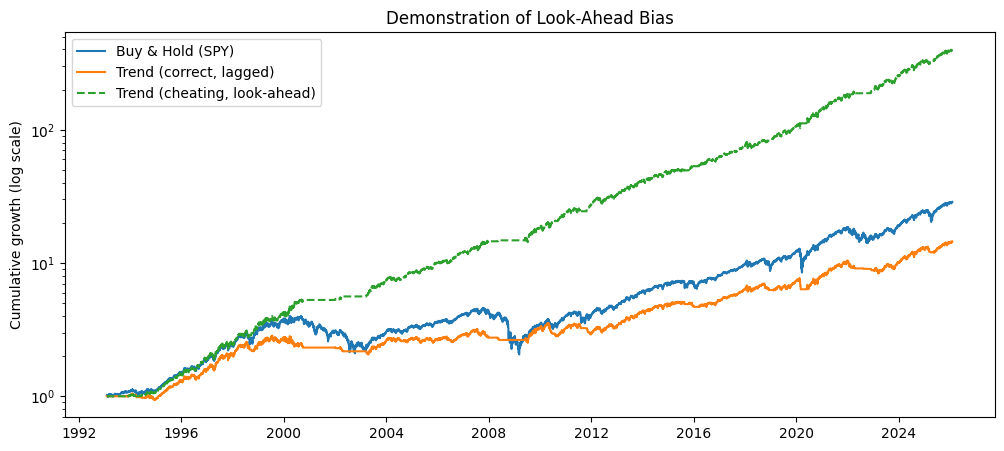

In [13]:
tmp = df.dropna(subset=["ret_strategy_cheat", "ret_strategy_correct", "ret_simple"]).copy()

tmp["cum_buy_hold"] = (1 + tmp["ret_simple"]).cumprod()
tmp["cum_cheat"] = (1 + tmp["ret_strategy_cheat"]).cumprod()
tmp["cum_correct"] = (1 + tmp["ret_strategy_correct"]).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(tmp.index, tmp["cum_buy_hold"], label="Buy & Hold (SPY)")
plt.plot(tmp.index, tmp["cum_correct"], label="Trend (correct, lagged)")
plt.plot(tmp.index, tmp["cum_cheat"], label="Trend (cheating, look-ahead)", linestyle="--")
plt.yscale("log")
plt.title("Demonstration of Look-Ahead Bias")
plt.ylabel("Cumulative growth (log scale)")
plt.legend()
plt.show()

In [14]:
def summary_stats(r: pd.Series, name: str) -> pd.Series:
    r = r.dropna()
    ann_return = (1 + r).prod() ** (252 / len(r)) - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan
    return pd.Series({
        "annual_return": ann_return,
        "annual_vol": ann_vol,
        "sharpe_like": sharpe,
        "n_days": len(r)
    }, name=name)

stats = pd.concat([
    summary_stats(tmp["ret_simple"], "buy_hold"),
    summary_stats(tmp["ret_strategy_correct"], "trend_correct"),
    summary_stats(tmp["ret_strategy_cheat"], "trend_cheat"),
], axis=1).T

stats

,annual_return,annual_vol,sharpe_like,n_days
buy_hold,0.107146,0.186149,0.575591,8309.0
trend_correct,0.084374,0.119801,0.704282,8309.0
trend_cheat,0.199029,0.118757,1.675934,8309.0


In [15]:
OUT_PATH = Path("../data/processed/SPY_with_signal.csv")

df_signal.to_csv(OUT_PATH, index=True)
print(f"Saved signal data to {OUT_PATH}")

Saved signal data to ../data/processed/SPY_with_signal.csv
